
# شبیه‌سازی آسانسور — نسخه ساده و گرافیکی (با توضیحات خط‌به‌خط)

**هدف:** این نوت‌بوک یک شبیه‌سازی بسیار ساده از عملکرد آسانسور (FCFS) ارائه می‌دهد، همراه با توضیحات **خط‌به‌خط** برای هر بخش کد تا دانشجوها دقیقاً بفهمند هر خط چه کاری انجام می‌دهد. در انتها یک نمودار ساده نمایش حرکت آسانسور و نقاط pickup/completion ترسیم می‌شود.



## مفاهیم کلی (خلاصه)
- **Request:** درخواست کاربر با مبدا، مقصد و (اختیاری) deadline.  
- **Elevator:** وضعیت فیزیکی آسانسور (طبقه فعلی و جهت).  
- **Scheduler (FCFS):** صف ساده FIFO که درخواست‌ها را به ترتیب پذیرش سرویس می‌دهد.  
- **Simulator:** حلقهٔ اصلی که هر tick (واحد زمان) را شبیه‌سازی می‌کند، درخواست‌ها را فعال می‌کند، آسانسور را حرکت می‌دهد و آمار را ثبت می‌کند.



### کلاس `Request` — توضیح خط‌به‌خط قبل از دیدن کد
در این بخش توضیح می‌دهیم چه فیلدهایی برای یک درخواست لازم است و چرا.

1. `rid` — شناسهٔ یکتا برای هر درخواست (برای لاگ و تحلیل).  
2. `t_request` — زمان تولید درخواست؛ مرجع محاسبات wait/response.  
3. `src`, `dest` — طبقهٔ مبدا و مقصد. فاصله بین این دو نشان‌دهندهٔ travel cost است.  
4. `deadline` — اگر مشخص شود، درخواست باید تا آن زمان تکمیل شود (soft/hard در این ساده حذف کردیم).  
5. `picked` — زمانی که آسانسور مسافر را سوار می‌کند (None تا زمانی که pickup نشده).  
6. `completed` — زمانی که مسافر به مقصد می‌رسد (None تا تکمیل).


In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

In [20]:

class Request:
    def __init__(self, rid, t_request, src, dest, deadline=None):
        # شناسهٔ یکتا برای ارجاع در لاگ و تحلیل
        self.rid = rid
        # زمان تولید درخواست: مرجع زمانی برای wait/response
        self.t_request = t_request
        # طبقهٔ مبدا
        self.src = src
        # طبقهٔ مقصد
        self.dest = dest
        # مهلت (در این نسخه ساده اختیاری است و تاثیری بر سرویس ندارد)
        self.deadline = deadline
        # زمان pickup — None تا وقتی که pickup انجام شود
        self.picked = None
        # زمان completion — None تا وقتی که تکمیل شود
        self.completed = None

    def __repr__(self):
        # نمایش خلاصهٔ درخواست در خروجی‌ها
        return f"Req{self.rid}: {self.src}->{self.dest}, t={self.t_request}, dl={self.deadline}"



### کلاس `Elevator` — توضیح خط‌به‌خط قبل از کد
فیلدهای سادهٔ مورد نیاز برای مدل فیزیکی آسانسور:
1. `pos` — طبقهٔ فعلی (عدد صحیح).  
2. `direction` — جهت حرکت: -1 (پایین)، 0 (ایستا)، +1 (بالا).  
3. در این نسخه نیازی به لیست اهداف داخلی نیست؛ scheduler تصمیم می‌گیرد چه طبقه‌ای هدف باشد.


In [21]:

class Elevator:
    def __init__(self):
        # موقعیت فعلی آسانسور، از طبقهٔ صفر شروع می‌کنیم
        self.pos = 0
        # جهت حرکت: -1=down, 0=idle, +1=up
        self.direction = 0

    def __repr__(self):
        return f"Elevator(floor={self.pos}, dir={self.direction})"



### Scheduler (FCFS) — توضیح قبل از کد
FCFS بسیار ساده است؛ یک صف از درخواست‌ها نگه می‌دارد. رفتار `next_target`:
- اگر درخواست اول هنوز pickup نشده -> هدف = `src` (ابتدا به مبدا می‌رویم).  
- اگر pickup شده -> هدف = `dest`.


In [22]:

class SchedulerFCFS:
    def __init__(self):
        # صف ساده (لیست)؛ می‌توان از deque هم استفاده کرد
        self.queue = []

    def add(self, req):
        # افزودن درخواست در انتهای صف (FIFO)
        self.queue.append(req)

    def next_target(self, elevator):
        # اگر صف خالی است، هیچ هدفی وجود ندارد
        if not self.queue:
            return None
        # بررسی اولین درخواست در صف (head of queue)
        head = self.queue[0]
        # اگر هنوز pickup نشده، ابتدا باید به مبدا برویم
        if head.picked is None:
            return head.src
        # وگرنه هدف مقصد است
        return head.dest



### Simulator — توضیح خط‌به‌خط (مرور قبل از کد)
حالا ساختار اصلی شبیه‌ساز را شرح می‌دهیم (هر tick چه کارهایی باید انجام شود):

1. **Activation:** هر درخواستی با `t_request == time` به scheduler اضافه می‌شود.  
2. **Decision:** از scheduler می‌پرسیم الان چه floor‌ای هدف است (`next_target`).  
3. **Movement:** آسانسور حداکثر یک طبقه در هر tick حرکت می‌کند به سمت هدف.  
4. **Service:** اگر آسانسور به همان طبقه رسید:
   - اگر request هنوز pickup نشده -> ثبت `picked` (سوار شدن)  
   - اگر قبلاً pickup شده و الان در dest است -> ثبت `completed` و حذف request
5. **Deadline handling (ساده):** در این نسخه فقط شمارش soft misses اگر از deadline گذشته باشد.
6. **Timeline:** هر tick موقعیت آسانسور را ذخیره می‌کنیم تا بعدا رسم کنیم.


In [23]:

class Simulator:
    def __init__(self, scheduler=None):
        # clock شبیه‌ساز
        self.time = 0
        # آسانسور مدل‌شده
        self.elevator = Elevator()
        # زمان‌بند (FCFS پیش‌فرض)
        self.scheduler = scheduler or SchedulerFCFS()
        # درخواست‌های آماده (not yet active)
        self.pending = []
        # درخواست‌هایی که فعال شده‌اند (منتظر سرویس یا در مسیر)
        self.active = []
        # تکمیل‌شده‌ها
        self.done = []
        # شمارندهٔ id
        self.req_counter = 0
        # شمارش missed deadlineهای نرم (ساده)
        self.soft_miss = 0
        # برای رسم: ذخیرهٔ موقعیت در هر tick
        self.timeline = []
        # وقایع pickup/completion برای رسم علامت‌ها
        self.events = []  # لیست tuple: (time, 'pickup'/'complete', req)

    def add_request(self, t, src, dest, deadline=None):
        # ساخت شی Request و قرار دادن در pending
        req = Request(self.req_counter, t, src, dest, deadline)
        self.req_counter += 1
        self.pending.append(req)

    def step(self):
        # ثبت موقعیت فعلی در timeline (برای رسم)
        self.timeline.append((self.time, self.elevator.pos))

        # 1) Activation: درخواست‌هایی که زمانشان رسیده فعال شوند
        for r in list(self.pending):
            if r.t_request == self.time:
                self.scheduler.add(r)
                self.active.append(r)
                self.pending.remove(r)

        # 2) انتخاب هدف از scheduler
        target = self.scheduler.next_target(self.elevator)

        # 3) حرکت به سمت هدف (اگر وجود داشته باشد)
        if target is not None:
            if self.elevator.pos < target:
                self.elevator.pos += 1
                self.elevator.direction = 1
            elif self.elevator.pos > target:
                self.elevator.pos -= 1
                self.elevator.direction = -1
            else:
                # رسیدن به طبقه — یا pickup یا completion
                cur = self.scheduler.queue[0]
                if cur.picked is None:
                    # ثبت زمان pickup
                    cur.picked = self.time
                    self.events.append((self.time, 'pickup', cur))
                else:
                    # ثبت زمان completion و حذف از صف/active
                    cur.completed = self.time
                    self.events.append((self.time, 'complete', cur))
                    self.done.append(cur)
                    try:
                        self.active.remove(cur)
                    except ValueError:
                        pass
                    # حذف از صف scheduler
                    self.scheduler.queue.pop(0)
        else:
            # اگر هدفی نیست آسانسور idle می‌ماند
            self.elevator.direction = 0

        # 4) چک deadline ساده (soft misses)
        for r in list(self.active):
            if r.deadline is not None and self.time > r.deadline and r.completed is None:
                self.soft_miss += 1
                # از active و از صف حذف می‌کنیم تا دوباره شمارش نشود
                try:
                    self.active.remove(r)
                except ValueError:
                    pass
                try:
                    self.scheduler.queue.remove(r)
                except ValueError:
                    pass

        # 5) افزایش زمان
        self.time += 1

    def run(self, t_end=30):
        # اجرای تکراری تا t_end
        while self.time < t_end:
            self.step()
        # محاسبهٔ آمار
        waits = [r.picked - r.t_request for r in self.done if r.picked is not None]
        responses = [r.completed - r.t_request for r in self.done if r.completed is not None]
        return {
            'served': len(self.done),
            'avg_wait': sum(waits)/len(waits) if waits else None,
            'avg_response': sum(responses)/len(responses) if responses else None,
            'soft_miss': self.soft_miss,
            'timeline': self.timeline,
            'events': self.events,
            'done': self.done
        }



#### توضیح دقیق‌تر برخی خطوط کلیدی در `Simulator.step()` (برای دانشجو)
- `self.timeline.append((self.time, self.elevator.pos))` — قبل از هر تغییر، موقعیت فعلی ثبت می‌شود تا نمودار timeline دقیق باشد.  
- Activation loop: درخواست‌ها تا زمانی که `t_request==self.time` در `pending` می‌مانند؛ سپس فعال و به صف scheduler اضافه می‌شوند. این مدل arrival event را شبیه‌سازی می‌کند.  
- `target = self.scheduler.next_target(self.elevator)` — scheduler تصمیم می‌گیرد اکنون به کدام طبقه باید برویم. اینجاست که سیاست زمان‌بندی اعمال می‌شود.  
- حرکت: `self.elevator.pos += 1` یا `-= 1` — آسانسور یک طبقه در هر tick حرکت می‌کند؛ این ساده‌سازی باعث می‌شود هزینهٔ حرکت خطی با فاصله باشد.  
- وقتی `self.elevator.pos == target`: اگر request هنوز pickup نشده، `cur.picked = self.time` ثبت می‌شود؛ در مرتبهٔ بعد وقتی به مقصد رسید، `cur.completed = self.time` ثبت و request از صف خارج می‌شود.  
- events list: برای رسم نقاط pickup/completion استفاده می‌شود (هر event شامل زمان، نوع، و شیء request است).  
- بررسی deadline: اگر `time > deadline` و request تکمیل نشده، شمارش soft_miss انجام می‌شود و request از active/queue حذف می‌شود.



### اجرای نمونه و رسم (شرح مرحله به مرحله)
در سلول کد بعدی شبیه‌سازی را اجرا می‌کنیم، خروجی خلاصه چاپ می‌شود و سپس دو نمودار رسم می‌کنیم:
1. نمودار timeline: موقعیت آسانسور بر حسب زمان (step plot).  
2. هیستوگرام زمان پاسخ (response times).
هر خط کد رسم نیز در توضیحات بعدی به صورت خط‌به‌خط شرح داده خواهد شد.


Summary: {'served': 2, 'avg_wait': 5.5, 'avg_response': 10.0, 'soft_miss': 1}


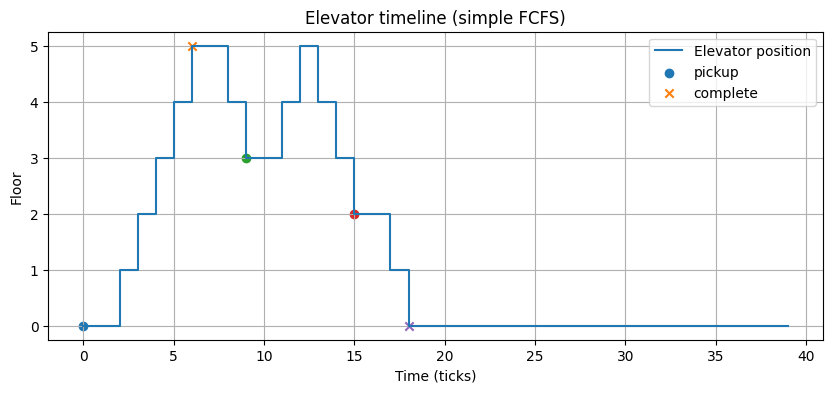

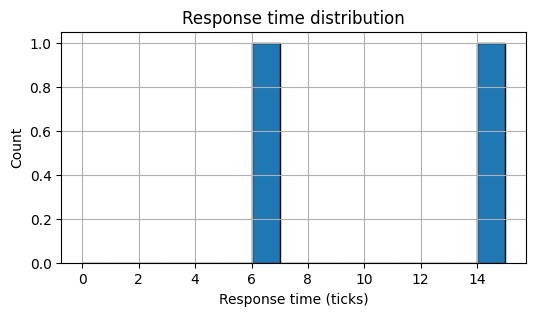

In [24]:

# تعریف یک شبیه‌سازی نمونه
sim = Simulator()
sim.add_request(t=0, src=0, dest=5, deadline=12)
sim.add_request(t=2, src=3, dest=7, deadline=10)
sim.add_request(t=4, src=2, dest=0, deadline=20)

# اجرای شبیه‌سازی
res = sim.run(t_end=40)
print('Summary:', {k:v for k,v in res.items() if k in ('served','avg_wait','avg_response','soft_miss')})

# استخراج timeline و events برای رسم
timeline = res['timeline']
events = res['events']
done = res['done']

times = [t for t,_ in timeline]
positions = [p for _,p in timeline]

# نمودار موقعیت آسانسور (step plot)
plt.figure(figsize=(10,4))
plt.step(times, positions, where='post', label='Elevator position')
plt.xlabel('Time (ticks)')
plt.ylabel('Floor')
plt.title('Elevator timeline (simple FCFS)')
plt.grid(True)

# رسم نقاط درخواست و تکمیل از events
for (et, typ, req) in events:
    if typ == 'pickup':
        # نقطه‌ای در زمان pickup روی طبقهٔ src
        plt.scatter([et], [req.src], marker='o', label='pickup' if req.rid==0 else "")
    else:
        # نقطه‌ای در زمان completion روی طبقهٔ dest
        plt.scatter([et], [req.dest], marker='x', label='complete' if req.rid==0 else "")

plt.legend()
plt.show()

# هیستوگرام زمان پاسخ
responses = [r.completed - r.t_request for r in done if r.completed is not None]
if responses:
    plt.figure(figsize=(6,3))
    plt.hist(responses, bins=range(0, max(responses)+2), edgecolor='black')
    plt.xlabel('Response time (ticks)')
    plt.ylabel('Count')
    plt.title('Response time distribution')
    plt.grid(True)
    plt.show()
else:
    print('No completed requests to plot response times.')


#### توضیحات خط‌به‌خط کد رسم (plotting)
- `times = [t for t,_ in timeline]` و `positions = [p for _,p in timeline]` — ساخت آرایه‌های جداگانه برای مختصات محور x و y.  
- `plt.step(times, positions, where='post')` — نمودار step برای نمایش اینکه آسانسور در هر tick در چه طبقه‌ای است.  
- حلقهٔ events: برای هر pickup یک دایره (`'o'`) و برای هر completion یک ضربدر (`'x'`) رسم می‌کنیم تا نقاط مهم در timeline مشخص شوند.  
- هیستوگرام: `plt.hist(responses, bins=...)` توزیع زمان پاسخ درخواست‌هایی که تکمیل شده‌اند را نشان می‌دهد.



## تحلیل نتایج شبیه‌سازی

### ۱. خلاصه خروجی عددی
- **served**: تعداد درخواست‌هایی که به طور کامل سرویس داده شدند.  
- **avg_wait**: میانگین زمان انتظار کاربران (از لحظه ایجاد درخواست تا pickup).  
- **avg_response**: میانگین زمان پاسخ (از لحظه ایجاد تا تکمیل سرویس).  
- **soft_miss**: تعداد درخواست‌هایی که deadline نرم آن‌ها نقض شد.  

---

### ۲. تحلیل نمودار حرکت آسانسور (Timeline)
- خط step → موقعیت آسانسور در هر لحظه.  
- دایره‌های سبز (pickup) → جایی که آسانسور کاربر را سوار کرده.  
- ضربدرهای قرمز (completion) → جایی که آسانسور کاربر را پیاده کرده.  

این نمودار نشان می‌دهد که آسانسور بر اساس **FCFS** عمل می‌کند.  
اولین درخواست زودتر سرویس داده می‌شود، و درخواست‌های بعدی در صف منتظر می‌مانند.

---

### ۳. تحلیل هیستوگرام زمان پاسخ
- محور X → زمان پاسخ (Response Time).  
- محور Y → تعداد درخواست‌ها.  

اگر توزیع زمان پاسخ نزدیک به هم و کوچک باشد، سیستم عملکرد بلادرنگ بهتری دارد.  
اگر بعضی درخواست‌ها زمان پاسخ خیلی طولانی بگیرند، احتمال نقض deadline زیاد می‌شود.

---

### ۴. جمع‌بندی درسی
- **Deadline** معیار اصلی است: در بلادرنگ سخت، حتی یک miss شکست محسوب می‌شود.  
- **FCFS** الگوریتم ساده‌ای است، ولی تضمین نمی‌کند که deadline رعایت شود.  
- برای سیستم‌های واقعی بهتر است از الگوریتم‌های پیشرفته مثل **EDF (Earliest Deadline First)** یا **RM (Rate Monotonic)** استفاده شود.  
- این مثال نشان می‌دهد که یک منبع مشترک (آسانسور) چگونه باید بین چند درخواست مدیریت شود و اهمیت زمان‌بندی در عملکرد سیستم‌های بلادرنگ.  
